In [1]:
import json
import pickle
import numpy as np
import pandas as pd

# TODOs
1. Simpler motion strategy
2. Simpler bb strategy
3. Use mostly square bb
4. See if prompts are bad

## Final Evaluation

In [2]:
# calculate IoU for the masks
import pickle as pkl
import numpy as np
import os
import torch
import torch.nn.functional as F

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / (np.sum(union) + 1e-5)
    return iou_score

# write a function to calculate AP50
def calculate_ap50(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    # print(intersection.shape, union.shape)
    iou_score = np.sum(intersection, axis=(-1,-2)) / (np.sum(union, axis=(-1,-2)) + 1e-5)
 
    non_zero_prediction_mask = np.sum(mask2, axis=(-1,-2)) > 0
 
    iou_score = iou_score[non_zero_prediction_mask]
    ap50 = np.where(iou_score >= 0.5, 1, 0)
    return np.mean(ap50)

def get_centroid(mask):
    x_argmax = np.argmax(np.sum(mask, axis=(-1)), axis=-1)
    y_argmax = np.argmax(np.sum(mask, axis=(-2)), axis=-1)
    x_rev_argmax = np.argmax(np.cumsum(np.sum(mask, axis=(-1)),axis=-1), axis=-1)
    y_rev_argmax = np.argmax(np.cumsum(np.sum(mask, axis=(-2)),axis=-1), axis=-1)
    cent_x = (x_argmax + x_rev_argmax) / 2
    cent_y = (y_argmax + y_rev_argmax) / 2
    
    centroid = np.stack([cent_x, cent_y], axis=1)
    return centroid
    # return np.linalg.norm(centroid - actual_centr) #+np.linalg.norm(288-cent_y[0])) / 2
    # np.abs(170-cent_x[0])+np.abs(288-cent_y[0])

def calculate_centroid_distance(mask1, mask2):
    c1 = get_centroid(mask1)
    c2 = get_centroid(mask2)
    dist = np.linalg.norm((c1 - c2), ord=2, axis=-1).mean()
    return dist


# video_filename = '0_of_40_2.mp4'
# with open(f"/home/yasjain/codebase/t2v/iou_eval/ssv2_modelscope_{video_filename.split('.')[0]}_bbox-v2.pkl", "rb") as f:
#     data = pkl.load(f)

# # load the masks
# masks = {}
# for d in data:
#     if d['num_bb'] >= 12:
#         masks[d['video']] = np.stack(d['mask'])

/opt/miniconda/envs/text_2_video/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import pickle
import pandas
pickles = [
        #    "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/custom_small_simple_corrected_tempattn/bbox_2_of_40_2_simple_small.pkl",    
        #     "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/custom_small_simple_corrected_tempattn/bbox_3_of_40_2_simple_small.pkl",
        #    "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/custom_small_simple_corrected_tempattn/bbox_4_of_40_2_simple_small.pkl",
        #    "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/custom_moving_simple_corrected_tempattn/bbox_3_of_40_2_simple_moving.pkl",
        #    "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/custom_moving_simple_corrected_tempattn/bbox_4_of_40_2_simple_moving.pkl",
        #    "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/custom_moving_simple_corrected_tempattn/bbox_3_of_40_2_simple_stationary.pkl",
        #    "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/custom_moving_simple_corrected_tempattn/bbox_2_of_40_2_simple_stationary.pkl",
           #    "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/custom_moving_simple_corrected_tempattn/bbox_4_of_40_2_simple_stationary.pkl",   
        #    "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op/bbox_0_of_40_2_modelscope.pkl",       
        #    "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op/bbox_1_of_40_2_modelscope.pkl",       
        #    "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op/bbox_2_of_40_2_modelscope.pkl",       
        #    "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op/bbox_3_of_40_2_modelscope.pkl",       
        #    "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op/bbox_4_of_40_2_modelscope.pkl",       
           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op_zeroscope/bbox_0_of_40_2_zeroscope.pkl",       
           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op_zeroscope/bbox_1_of_40_2_zeroscope.pkl",       
           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op_zeroscope/bbox_2_of_40_2_zeroscope.pkl",       
           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op_zeroscope/bbox_3_of_40_2_zeroscope.pkl",       
           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op_zeroscope/bbox_4_of_40_2_zeroscope.pkl",     
           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op_zeroscope/bbox_5_of_40_2_zeroscope.pkl",     
           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op_zeroscope/bbox_6_of_40_2_zeroscope.pkl",     


           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op/bbox_0_of_40_2_modelscope.pkl",       
           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op/bbox_1_of_40_2_modelscope.pkl",       
           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op/bbox_2_of_40_2_modelscope.pkl",       
           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op/bbox_3_of_40_2_modelscope.pkl",       
           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op/bbox_4_of_40_2_modelscope.pkl",     
           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op/bbox_5_of_40_2_modelscope.pkl",     
           "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/filtered_op/bbox_6_of_40_2_modelscope.pkl",   

           
         #   "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/ablation_ca_zeroscope/bbox_3_of_40_2_ablation_ca_interpolate_zeroscope.pkl",     
         #   "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/ablation_sa_zeroscope/bbox_3_of_40_2_ablation_sa_interpolate_zeroscope.pkl",     
         #   "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/ablation_ta_zeroscope/bbox_3_of_40_2_ablation_ta_interpolate_zeroscope.pkl",     


         #   "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/ablation_ca_zeroscope/bbox_3_of_40_2_ablation_ca_zeroscope.pkl",     
         #   "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/ablation_sa_zeroscope/bbox_3_of_40_2_ablation_sa_zeroscope.pkl",     
         #   "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/ablation_ta_zeroscope/bbox_3_of_40_2_ablation_ta_zeroscope.pkl",               
           ]

datasets = [pickle.load(open(x, "rb")) for x in pickles]

In [3]:

def process(data):
    new_data = []
    for rec in data:
        new_rec = {}
        if rec['frames'][0].shape != rec['mask'][0].shape:
            rec['frames'] = F.interpolate(torch.tensor(rec['frames']).unsqueeze(0).float(), size=(rec['mask'][0].shape[0], rec['mask'][0].shape[1]), mode='bilinear', align_corners=True).squeeze(0).round().numpy()
        if len(rec['frames']) != len(rec['mask']):
            min_len = min(len(rec['mask']), len(rec['frames']))
            rec['frames'] = rec['frames'][:min_len]
            rec['mask'] = rec['mask'][:min_len]
        
        rec['iou'] = calculate_iou(rec['frames'], rec['mask'])
        rec['ap50'] = calculate_ap50(rec['frames'], rec['mask'])
        rec['centroid_dist'] = calculate_centroid_distance(rec['frames'], rec['mask'])
        rec['gt_area'] = np.sum(rec['frames'])
        rec['pred_area'] = np.sum(rec['mask'])
        # if rec['gt_area'] < 100000: continue
        # if rec['num_']
        for key in rec:
            if 'frame' in key or 'mask' in key: continue
            new_rec[key] = rec[key]
                        
        # print(rec.keys())
        # raise Exception
        new_data.append(new_rec)
    return new_data

data_with_results = [process(x) for x in datasets]

/opt/miniconda/envs/text_2_video/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda/envs/text_2_video/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_29245/3467637415.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  rec['frames'] = F.interpolate(torch.tensor(rec['frames']).unsqueeze(0).float(), size=(rec['mask'][0].shape[0], rec['mask'][0].shape[1]), mode='bilinear', align_corners=True).squeeze(0).round().numpy()


In [4]:
# del datasets
# [len(x) for x in data_with_results]
# import numpy as np
# print([np.mean(y['iou']) for x in data_with_results for y in x ])
# print([np.mean(y['num_bb']) for x in data_with_results for y in x])
# print([np.mean(y['centroid_dist']) for x in data_with_results for y in x])
import pandas as pd
dfs = [pd.DataFrame(x) for x in data_with_results]

In [ ]:
BAD_SUBJECTS = ['bat', 'clock tower', 'lighthouse', 'peacock', 'mural', 'windmill', 'monument', 'wooden bridge', 'statue', 'gazebo', 'cat', 'cheetah', 'clock', 'fountain', 'castle', 'skyscraper', 'gondola', 'ferris wheel',
                'goat', 'mountain goat', 'koala', 'bicycle rider', 'sculpture', 'raccoon', 'cabin', 'train']  # Vintage ccar with stationary 
BAD_SUBJECTS = ['telephone box', 'spider', 'steam train', 'vintage car', 'grand piano', 'sailboat', 'street lamp']
for filename,df in zip(pickles, dfs):
    # print(df['iou'].mean(), df['centroid_dist'].mean(), df['num_bb'].mean())
    try:
        df['subject'] = df['subject'].str.lower().str.strip()
        df_filtered = df[~df['subject'].isin(BAD_SUBJECTS)]
        print('/'.join(filename.split('/')[-2:]))
        # print(df_filtered['subject'])
        df_filtered['area_ratio'] = abs(df_filtered['gt_area']-df_filtered['pred_area']) / df_filtered['gt_area']
        df_filtered['dist'] = df_filtered['centroid_dist'] / (np.linalg.norm([320, 576]))
        df_filtered['ap_50_num_bb'] = df_filtered['ap50'] * df_filtered['num_bb']
        # Create a new column which is a multiplication of iou and (num_bb > 12)
        df_filtered['iou_numbb'] = df_filtered['iou'] * (df_filtered['num_bb'] > 12)
        df_filtered['num_bb_cov'] = (df_filtered['num_bb'] > 12)
        # df_filtered['iou_numbb'] = df_filtered['ap50'] * df_filtered['num_bb']
        print(df_filtered.groupby('subject')[['num_bb', 'iou', 'dist', 'area_ratio']].mean().sort_values(by='iou', ascending=True))
        # print(df_filtered.groupby('subject')[['num_bb', 'iou', 'dist', 'area_ratio']].mean().sort_values(by='iou', ascending=True))
        # print(df_filtered.groupby('subject')[['gt_area']].mean()) # .sort_values(by='iou', ascending=True))
        # print(df_filtered['prompt'].to_csv())
        print(f"{df_filtered['ap50'].mean()}, {df_filtered['iou'].mean()} {(df_filtered['iou_numbb'].sum() / (df_filtered['num_bb_cov'].sum()))*100:.1f} & {df_filtered['num_bb_cov'].mean()} & {df_filtered['dist'].mean():.2f} & {df_filtered['ap_50_num_bb'].sum() / df_filtered['num_bb'].sum() * 100:.1f} , {len(df_filtered)}")
        print("-"*10)
    except:
        continue
    

In [44]:
import pickle
import pandas
pickles = [
           "/scr/ssv2_results/iou_eval/ssv2_modelscope_0_of_40_2_bbox-v2.pkl",
           "/scr/ssv2_results/iou_eval/ssv2_modelscope_2_of_40_2_bbox-v2.pkl"
           #    "/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/custom_moving_simple_corrected_tempattn/bbox_4_of_40_2_simple_stationary.pkl",           
           ]

datasets = [pickle.load(open(x, "rb")) for x in pickles]

In [42]:
gt_file = '/gscratch/sewoong/anasery/datasets/ssv2/datasets/SSv2/SSv2_label_with_masks.pkl'
gt_ds = pickle.load(open(gt_file, 'rb'))

In [54]:

def process(data):
    new_data = []
    for rec in data:
        new_rec = {}
        found = False
        for v in gt_ds:
            if v['video'] == rec['video']:
                found = True
                break
        if not found:
            print(v['video'], "Not found")
            continue
        rec['frames'] = v['mask']
        if rec['frames'][0].shape != rec['mask'][0].shape:
            rec['frames'] = F.interpolate(torch.tensor(rec['frames']).unsqueeze(0).float(), size=(rec['mask'][0].shape[0], rec['mask'][0].shape[1]), mode='bilinear', align_corners=True).squeeze(0).round().numpy()
        if len(rec['frames']) != len(rec['mask']):
            min_len = min(len(rec['mask']), len(rec['frames']))
            rec['frames'] = rec['frames'][:min_len]
            rec['mask'] = rec['mask'][:min_len]
        rec['iou'] = calculate_iou(rec['frames'], rec['mask'])
        rec['ap50'] = calculate_ap50(rec['frames'], rec['mask'])
        rec['centroid_dist'] = calculate_centroid_distance(rec['frames'], rec['mask'])
        rec['gt_area'] = np.sum(rec['frames'])
        rec['pred_area'] = np.sum(rec['mask'])
        if rec['gt_area'] < 5: continue
        if rec['num_bb'] < int(0.5*len(rec['frames'])): continue
        for key in rec:
            if 'frame' in key or 'mask' in key: continue
            new_rec[key] = rec[key]
                        
        # print(rec.keys())
        # raise Exception
        new_data.append(new_rec)
    return new_data

data_with_results = [process(x) for x in datasets]

In [57]:
# del datasets
# [len(x) for x in data_with_results]
# import numpy as np
# print([np.mean(y['iou']) for x in data_with_results for y in x ])
# print([np.mean(y['num_bb']) for x in data_with_results for y in x])
# print([np.mean(y['centroid_dist']) for x in data_with_results for y in x])
import pandas as pd
dfs = [pd.DataFrame(x) for x in data_with_results]

In [64]:
BAD_SUBJECTS = ['bat', 'clock tower', 'lighthouse', 'peacock', 'mural', 'windmill', 'monument', 'wooden bridge', 'statue', 'gazebo', 'cat', 'cheetah', 'clock', 'fountain', 'castle', 'skyscraper', 'gondola', 'ferris wheel',
                'goat', 'mountain goat', 'koala', 'bicycle rider', 'sculpture', 'raccoon', 'cabin', 'train']  # Vintage ccar with stationary 

for filename,df in zip(pickles, dfs):
    # print(df['iou'].mean(), df['centroid_dist'].mean(), df['num_bb'].mean())
    df['subject'] = df['subject'].str.lower().str.strip()
    df_filtered = df[~df['subject'].isin(BAD_SUBJECTS)]
    print('/'.join(filename.split('/')[-2:]))
    # print(df_filtered['subject'])
    df_filtered['area_ratio'] = abs(df_filtered['gt_area']-df_filtered['pred_area']) / df_filtered['gt_area']
    df_filtered['dist'] = df_filtered['centroid_dist'] / (np.linalg.norm([320, 576]))
    # print(df_filtered.groupby('caption')[['num_bb', 'iou', 'dist', 'area_ratio']].mean().sort_values(by='iou', ascending=True))
    # print(df_filtered.groupby('subject')[['num_bb', 'iou', 'dist', 'area_ratio']].mean().sort_values(by='iou', ascending=True))
    # print(df_filtered.groupby('subject')[['gt_area']].mean()) # .sort_values(by='iou', ascending=True))
    # print(df_filtered['prompt'].to_csv())
    print(f"{df_filtered['iou'].mean()*100:.1f} &  & {df_filtered['dist'].mean():.2f} & {df_filtered['ap50'].mean()*100:.1f}")
    print("-"*10)
    

iou_eval/ssv2_modelscope_0_of_40_2_bbox-v2.pkl
11.5 &  & 0.15 & 3.3
----------
iou_eval/ssv2_modelscope_2_of_40_2_bbox-v2.pkl
34.4 &  & 0.08 & 33.9
----------


/tmp/ipykernel_24724/2892302028.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['area_ratio'] = abs(df_filtered['gt_area']-df_filtered['pred_area']) / df_filtered['gt_area']
/tmp/ipykernel_24724/2892302028.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['dist'] = df_filtered['centroid_dist'] / (np.linalg.norm([320, 576]))
/tmp/ipykernel_24724/2892302028.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [29]:
## LLM-VD eval


import pickle as pkl
gt_file = '/gscratch/sewoong/anasery/text_to_video/video_pipeline/Spatial-aware-T2V/preprocess_msr_vtt/custom_prompts_with_bb_all_large_filtered_modelscope.pkl'
with open(gt_file, "rb") as f:
    gt_data = pkl.load(f)

# with open(f"/gscratch/sewoong/anasery/text_to_video/clean_code/llm_vd/filtered_op_zeroscope_model_buggy/0_2_bbox.pkl", "rb") as f:
#     data_0 = pkl.load(f)
    
with open(f"/gscratch/sewoong/anasery/text_to_video/clean_code/llm_vd/filtered_op_modelscope_model/bbox.pkl", "rb") as f:
    data_0 = pkl.load(f)    
    
# with open(f"/gscratch/sewoong/anasery/peekaboo_rebuttal_results/modelscope_imc/3_of_40_2_bbox.pkl", "rb") as f:
#     data_0 = pkl.load(f)        
    
def process(data, gt_ds):
    new_data = []
    for rec in data:
        new_rec = {}
        found = False
        # print(rec['video'])
        for v in gt_ds:
            # print([key for key in v.keys()])
            if str(v['video_id']) == str(rec['video']):
                found = True
                break
        if not found:
            print(rec['video'], "Not found")
            continue
        rec['frames'] = v['frames']
        if rec['frames'][0].shape != rec['mask'][0].shape:
            rec['frames'] = F.interpolate(torch.tensor(rec['frames']).unsqueeze(0).float(), size=(rec['mask'][0].shape[0], rec['mask'][0].shape[1]), mode='bilinear', align_corners=True).squeeze(0).round().numpy()
        if len(rec['frames']) != len(rec['mask']):
            min_len = min(len(rec['mask']), len(rec['frames']))
            rec['frames'] = rec['frames'][:min_len]
            rec['mask'] = rec['mask'][:min_len]
        rec['iou'] = calculate_iou(rec['frames'], rec['mask'])
        rec['ap50'] = calculate_ap50(rec['frames'], rec['mask'])
        rec['centroid_dist'] = calculate_centroid_distance(rec['frames'], rec['mask'])
        rec['gt_area'] = np.sum(rec['frames'])
        rec['pred_area'] = np.sum(rec['mask'])
        if rec['gt_area'] < 5: continue
        if rec['num_bb'] < int(0.5*len(rec['frames'])): continue
        for key in rec:
            if 'frame' in key or 'mask' in key: continue
            new_rec[key] = rec[key]
                        
        # print(rec.keys())
        # raise Exception
        new_data.append(new_rec)
    return new_data


new_data = process(data_0, gt_data)

/opt/miniconda/envs/text_2_video/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda/envs/text_2_video/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [28]:
df = pd.DataFrame(new_data)
df['subject'] = df['subject'].str.lower().str.strip()
df_filtered = df
# df_filtered = df[~df['subject'].isin(BAD_SUBJECTS)]
# print('/'.join(filename.split('/')[-2:]))
# print(df_filtered['subject'])
df_filtered['area_ratio'] = abs(df_filtered['gt_area']-df_filtered['pred_area']) / df_filtered['gt_area']
df_filtered['dist'] = df_filtered['centroid_dist'] / (np.linalg.norm([256, 256]))
# print(df_filtered.groupby('caption')[['num_bb', 'iou', 'dist', 'area_ratio']].mean().sort_values(by='iou', ascending=True))
# print(df_filtered.groupby('subject')[['num_bb', 'iou', 'dist', 'area_ratio']].mean().sort_values(by='iou', ascending=True))
# print(df_filtered.groupby('subject')[['gt_area']].mean()) # .sort_values(by='iou', ascending=True))
# print(df_filtered['prompt'].to_csv())
print(f"{df_filtered['iou'].mean()*100:.1f} &  & {df_filtered['dist'].mean():.2f} & {df_filtered['ap50'].mean()*100:.1f}")
print("-"*10)

32.3 &  & 0.16 & 24.0
----------


In [63]:
## LLM-VD eval


import pickle as pkl
gt_file = '/gscratch/sewoong/anasery/datasets/ssv2/datasets/SSv2/SSv2_label_with_masks_single_subj-v2.pkl'
with open(gt_file, "rb") as f:
    gt_data = pkl.load(f)

# with open(f"/gscratch/sewoong/anasery/text_to_video/clean_code/llm_vd/filtered_op_zeroscope_model_buggy/0_2_bbox.pkl", "rb") as f:
#     data_0 = pkl.load(f)
    
with open(f"/gscratch/sewoong/anasery/text_to_video/clean_code/llm_vd/ssv2-modelscope/0_2_bbox.pkl", "rb") as f:
    data_0 = pkl.load(f)    
    
# with open(f"/gscratch/sewoong/anasery/peekaboo_rebuttal_results/modelscope_imc/3_of_40_2_bbox.pkl", "rb") as f:
#     data_0 = pkl.load(f)        


v_keys = [str(x['video'].strip('.mp4')) for x in gt_data]
d_keys = [str(x['video']) for x in data_0]


def mask_size(mask):
    return np.sqrt(np.sum(mask))
def mask_variance(masks):
    mask_sizes = [mask_size(x) for x in masks]
    mask_sizes = np.array(mask_sizes)
    normalized_variance = np.std(mask_sizes) / (np.mean(mask_sizes)+1e-15)
    return normalized_variance

    
def process(data, gt_ds):
    new_data = []
    for rec, v in zip(data, gt_ds):
        new_rec = {}
        found = False
        # print(rec['video'])
        # for v in gt_ds:
            # print(str(v['video']), str(rec['video']))
        if str(v['video'].strip('.mp4')) != str(rec['video']):
                print(f"Keys different for - {v['video'].strip('.mp4')}, {rec['video']}")
                # found = True
                continue
                # break
        # if not found:
        #     print(rec['video'], "Not found")
        #     continue
        rec['frames'] = v['mask']
        if rec['frames'][0].shape != rec['mask'][0].shape:
            rec['frames'] = F.interpolate(torch.tensor(rec['frames']).unsqueeze(0).float(), size=(rec['mask'][0].shape[0], rec['mask'][0].shape[1]), mode='bilinear', align_corners=True).squeeze(0).round().numpy()
        if len(rec['frames']) != len(rec['mask']):
            min_len = min(len(rec['mask']), len(rec['frames']))
            rec['frames'] = rec['frames'][:min_len]
            rec['mask'] = rec['mask'][:min_len]
        rec['iou'] = calculate_iou(rec['frames'], rec['mask'])
        rec['ap50'] = calculate_ap50(rec['frames'], rec['mask'])
        rec['centroid_dist'] = calculate_centroid_distance(rec['frames'], rec['mask'])
        rec['gt_area'] = np.sum(rec['frames'])
        rec['pred_area'] = np.sum(rec['mask'])
        new_rec['mask_variance'] = mask_variance(rec['frames'])
        if rec['gt_area'] < 5: continue
        if rec['num_bb'] < int(0.5*len(rec['frames'])): continue
        for key in rec:
            if 'frame' in key or 'mask' in key: continue
            new_rec[key] = rec[key]
                        
        # print(rec.keys())
        # raise Exception
        new_data.append(new_rec)
    return new_data


new_data = process(data_0, gt_data)

/opt/miniconda/envs/text_2_video/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda/envs/text_2_video/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Keys different for - 3862, 38624
Keys different for - 1999, 199944
Keys different for - 17829, 178294
Keys different for - 391, 44391
Keys different for - 15168, 151684
Keys different for - 827, 82744
Keys different for - 11132, 111324
Keys different for - 9542, 95424
Keys different for - 17476, 174764
Keys different for - 11469, 114694
Keys different for - 1185, 118544
Keys different for - 20439, 204394
Keys different for - 5058, 50584
Keys different for - 7303, 47303
Keys different for - 2616, 26164
Keys different for - 21198, 211984
Keys different for - 7229, 47229
Keys different for - 3313, 43313
Keys different for - 761, 4761
Keys different for - 15375, 153754
Keys different for - 13922, 139224
Keys different for - 533, 44533
Keys different for - 5980, 59804
Keys different for - 17493, 174934
Keys different for - 6796, 67964
Keys different for - 2395, 23954
Keys different for - 1491, 14914
Keys different for - 17868, 178684
Keys different for - 14657, 146574
Keys different for - 8

In [64]:
df = pd.DataFrame(new_data)
df['subject'] = df['subject'].str.lower().str.strip()
df_filtered = df
# df_filtered = df[~df['subject'].isin(BAD_SUBJECTS)]
# print('/'.join(filename.split('/')[-2:]))
# print(df_filtered['subject'])
df_filtered['area_ratio'] = abs(df_filtered['gt_area']-df_filtered['pred_area']) / df_filtered['gt_area']
df_filtered['dist'] = df_filtered['centroid_dist'] / (np.linalg.norm([256, 256]))
df_filtered['ap_50_num_bb'] = df_filtered['ap50'] * df_filtered['num_bb']
# Create a new column which is a multiplication of iou and (num_bb > 12)
df_filtered['iou_numbb'] = df_filtered['iou'] * (df_filtered['num_bb'] > 12)
df_filtered['num_bb_cov'] = (df_filtered['num_bb'] > 12)



df_filtered['area_ratio'] = abs(df_filtered['gt_area']-df_filtered['pred_area']) / df_filtered['gt_area']
df_filtered['dist'] = df_filtered['centroid_dist'] / (np.linalg.norm([256, 256]))
# print(df_filtered.groupby('caption')[['num_bb', 'iou', 'dist', 'area_ratio']].mean().sort_values(by='iou', ascending=True))
# print(df_filtered.groupby('subject')[['num_bb', 'iou', 'dist', 'area_ratio']].mean().sort_values(by='iou', ascending=True))
# print(df_filtered.groupby('subject')[['gt_area']].mean()) # .sort_values(by='iou', ascending=True))
# print(df_filtered['prompt'].to_csv())
print(f"{df_filtered['ap50'].mean()}, {df_filtered['iou'].mean()} {(df_filtered['iou_numbb'].sum() / (df_filtered['num_bb_cov'].sum()))*100:.1f} & {df_filtered['num_bb_cov'].mean()} & {df_filtered['dist'].mean():.2f} & {df_filtered['ap_50_num_bb'].sum() / df_filtered['num_bb'].sum() * 100:.1f} , {len(df_filtered)}")

# print(f"{df_filtered['iou'].mean()*100:.1f} &  & {df_filtered['dist'].mean():.2f} & {df_filtered['ap50'].mean()*100:.1f}")
print("-"*10)

0.18041896559860632, 0.24995109485278014 27.7 & 0.7365269461077845 & 0.19 & 18.1 , 167
----------


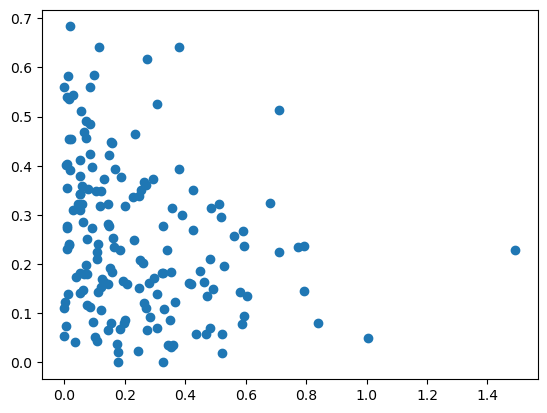

In [65]:
import matplotlib.pyplot as plt
plt.scatter(df_filtered['mask_variance'], df_filtered['iou'])

## LaSOT detailed Analysis

In [3]:
gt_path = '/gscratch/sewoong/anasery/datasets/LaSOT/lasot_bboxes_larger.pkl'
pred_path = '/gscratch/sewoong/anasery/peekaboo_rebuttal_results/modelscope_lasot/3_of_40_2_bbox.pkl'

In [8]:
## LLM-VD eval

import numpy as np
import pandas as pd
import pickle as pkl
gt_file = '/gscratch/sewoong/anasery/datasets/LaSOT/lasot_bboxes_larger.pkl'
with open(gt_file, "rb") as f:
    gt_data = pkl.load(f)

# with open(f"/gscratch/sewoong/anasery/text_to_video/clean_code/llm_vd/filtered_op_zeroscope_model_buggy/0_2_bbox.pkl", "rb") as f:
#     data_0 = pkl.load(f)
    
with open(f'/gscratch/sewoong/anasery/peekaboo_rebuttal_results/modelscope_lasot/3_of_40_2_bbox.pkl', "rb") as f:
    data_0 = pkl.load(f)    


with open(f'/gscratch/sewoong/anasery/peekaboo_rebuttal_results/modelscope_lasot/0_of_40_2_bbox.pkl', "rb") as f:
    data_2 = pkl.load(f)      
    
with open(f'/gscratch/sewoong/anasery/text_to_video/clean_code/llm_vd/lasot_results0_of_40_2_bbox.pkl', "rb") as f:
    data_3 = pkl.load(f)            
# with open(f"/gscratch/sewoong/anasery/peekaboo_rebuttal_results/modelscope_imc/3_of_40_2_bbox.pkl", "rb") as f:
#     data_0 = pkl.load(f)        


v_keys = [str(x['id']) for x in gt_data]
d_keys = [str(x['video']) for x in data_0]

# print([(x,y) for x,y in zip(v_keys, d_keys) if x == y])

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / (np.sum(union) + 1e-5)
    return iou_score

# write a function to calculate AP50
def calculate_ap50(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    # print(intersection.shape, union.shape)
    iou_score = np.sum(intersection, axis=(-1,-2)) / (np.sum(union, axis=(-1,-2)) + 1e-5)
 
    non_zero_prediction_mask = np.sum(mask2, axis=(-1,-2)) > 0
 
    iou_score = iou_score[non_zero_prediction_mask]
    ap50 = np.where(iou_score >= 0.5, 1, 0)
    return np.mean(ap50)

def get_centroid(mask):
    x_argmax = np.argmax(np.sum(mask, axis=(-1)), axis=-1)
    y_argmax = np.argmax(np.sum(mask, axis=(-2)), axis=-1)
    x_rev_argmax = np.argmax(np.cumsum(np.sum(mask, axis=(-1)),axis=-1), axis=-1)
    y_rev_argmax = np.argmax(np.cumsum(np.sum(mask, axis=(-2)),axis=-1), axis=-1)
    cent_x = (x_argmax + x_rev_argmax) / 2
    cent_y = (y_argmax + y_rev_argmax) / 2
    
    centroid = np.stack([cent_x, cent_y], axis=1)
    return centroid
    # return np.linalg.norm(centroid - actual_centr) #+np.linalg.norm(288-cent_y[0])) / 2
    # np.abs(170-cent_x[0])+np.abs(288-cent_y[0])

def calculate_centroid_distance(mask1, mask2):
    c1 = get_centroid(mask1)
    c2 = get_centroid(mask2)
    dist = np.linalg.norm((c1 - c2), ord=2, axis=-1).mean()
    return dist


def mask_size(mask):
    return np.sqrt(np.sum(mask))
def mask_variance(masks):
    mask_sizes = [mask_size(x) for x in masks]
    mask_sizes = np.array(mask_sizes)
    normalized_variance = np.std(mask_sizes) / (np.mean(mask_sizes)+1e-15)
    return normalized_variance

def get_mask_from_bb(bboxes, shape):
    all_bboxes = []
    bbox_present = []
    num_bb = 0
    for bbox in bboxes:
        try:
            # Get a zeros array of the same size as the frame
            canvas = np.zeros(shape)
            # Draw the bounding box on the canvas
            canvas[int(bbox[1]*shape[0]):int(bbox[3]*shape[0]), int(bbox[0]*shape[1]):int(bbox[2]*shape[1])] = 1
            # Add the canvas to the list of bounding boxes
            all_bboxes.append(canvas)
            bbox_present.append(True)
            num_bb += 1
        except Exception as e:
            # Append an empty canvas, we will interpolate later
            all_bboxes.append(np.zeros(shape))        
            bbox_present.append(False)    
            continue
    return all_bboxes

        
def process(data, gt_ds):
    new_data = []
    # all_orig_id = [str(v['id']).strip('.mp4') for v in gt_ds]
    # print(all_orig_id)
    printer_str = ""
    for rec in data:
        new_rec = {}
        found = False
        for v in gt_ds:
            try:
                orig_id = v['video'].strip('.mp4')
            except KeyError:
                orig_id = str(v['id'])
            if orig_id == '': orig_id = '4'
            if str(orig_id) == str(rec['video']): 
                found = True
                break
                # print(f"Keys different for - {orig_id}, {rec['video']}")
                # continue
                # break
        if not found:
            print(f"Could not find {rec['video']}")
            continue
        if 'mask' not in v:
            rec['frames'] = get_mask_from_bb(v['bboxes'], rec['mask'][0].shape)
        else:
            rec['frames'] = v['mask']
            
        if rec['frames'][0].shape != rec['mask'][0].shape:
            rec['frames'] = F.interpolate(torch.tensor(rec['frames']).unsqueeze(0).float(), size=(rec['mask'][0].shape[0], rec['mask'][0].shape[1]), mode='bilinear', align_corners=True).squeeze(0).round().numpy()
        if len(rec['frames']) != len(rec['mask']):
            min_len = min(len(rec['mask']), len(rec['frames']))
            rec['frames'] = rec['frames'][:min_len]
            rec['mask'] = rec['mask'][:min_len]
        rec['iou'] = calculate_iou(rec['frames'], rec['mask'])
        rec['ap50'] = calculate_ap50(rec['frames'], rec['mask'])
        rec['centroid_dist'] = calculate_centroid_distance(rec['frames'], rec['mask'])
        rec['gt_area'] = np.sum(rec['frames'])
        rec['pred_area'] = np.sum(rec['mask'])
        new_rec['mask_variance'] = mask_variance(rec['frames'])
        if rec['gt_area'] < 5: continue
        if rec['num_bb'] < int(0.5*len(rec['frames'])): continue
        for key in rec:
            if 'frame' in key or 'mask' in key: continue
            new_rec[key] = rec[key]
                        
        # print(v.keys())
        # raise Exception
        printer_str += f"{v['lasot_name'].strip()}, {rec['subject']}, {rec['iou']:.2f}, {rec['ap50']:.2f}, {rec['centroid_dist']:.2f}, {rec['gt_area']:.2f}, {rec['pred_area']:.2f}, {rec['num_bb']}, {new_rec['mask_variance']:.2f}\n"
        new_data.append(new_rec)
        # print()
    
    return new_data, printer_str



header_str = "LaSOT ID, Subject, iou, ap50, centroid_dist, gt bbox area, predicted video bbox area, detected number bboxes, mask_size_variance\n"
new_data, csv_str = process(data_0, gt_data)
csv_str = header_str + csv_str

_, csv_str_ms = process(data_2, gt_data)
csv_str_ms = header_str + csv_str_ms


_, csv_str_llmvd = process(data_3, gt_data)
csv_str_llmvd = header_str + csv_str_llmvd


/mmfs1/gscratch/sewoong/anasery/rebasin_merging/git-re-basin-fx/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mmfs1/gscratch/sewoong/anasery/rebasin_merging/git-re-basin-fx/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
from io import StringIO
df = pd.read_csv(StringIO(csv_str))
df_ms = pd.read_csv(StringIO(csv_str_ms))
df_llmvd = pd.read_csv(StringIO(csv_str_llmvd))

df.columns = df.columns.str.strip()
df_ms.columns = df_ms.columns.str.strip()
df_llmvd.columns = df_llmvd.columns.str.strip()

print(csv_str)


LaSOT ID, Subject, iou, ap50, centroid_dist, gt bbox area, predicted video bbox area, detected number bboxes, mask_size_variance
airplane-1, airplane, 0.00, 0.00, 175.09, 12042.00, 40718.00, 13, 0.10
airplane-1, airplane, 0.07, 0.00, 61.54, 19142.00, 253864.00, 16, 0.09
airplane-9, airplane, 0.00, 0.00, 108.70, 78.00, 34105.00, 10, 2.65
airplane-13, airplane, 0.04, 0.00, 16.49, 15840.00, 370231.00, 16, 0.25
airplane-13, airplane, 0.08, 0.00, 54.35, 60019.00, 208791.00, 16, 0.31
airplane-15, airplane, 0.04, 0.00, 62.30, 16833.00, 297371.00, 16, 0.75
airplane-15, airplane, 0.13, 0.00, 59.62, 60693.00, 74526.00, 15, 0.30
basketball-7, basketball, 0.04, 0.00, 106.80, 31560.00, 365483.00, 16, 1.24
bear-17, bear, 0.04, 0.00, 67.44, 45119.00, 87570.00, 16, 0.10
bird-3, bird, 0.06, 0.00, 116.28, 25906.00, 14181.00, 16, 1.72
bird-15, bird, 0.57, 0.56, 18.51, 173014.00, 263461.00, 16, 0.29
bird-15, bird, 0.43, 0.00, 22.34, 253982.00, 533462.00, 16, 0.07
bus-5, bus, 0.40, 0.19, 19.08, 122591.00, 

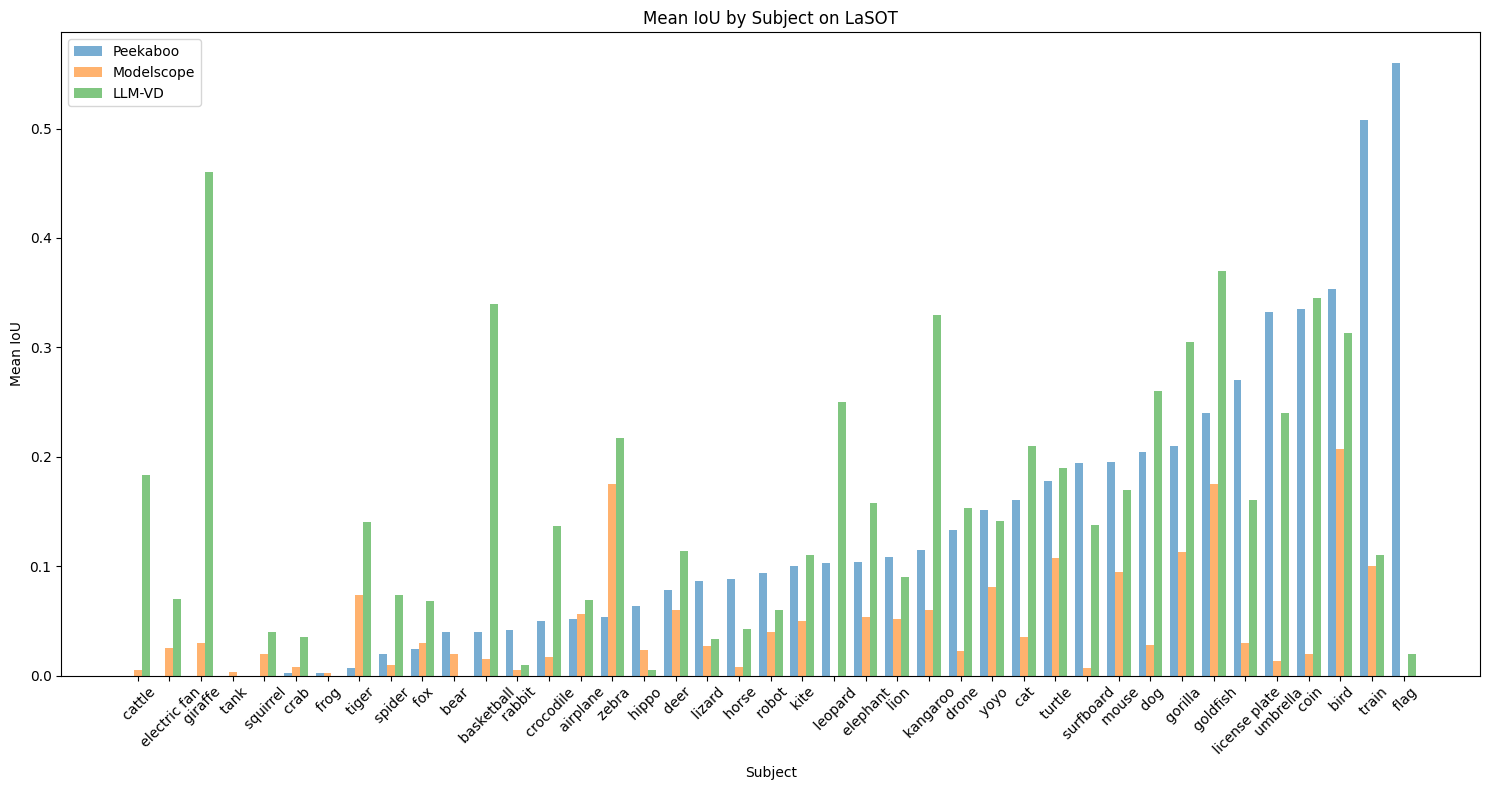

In [11]:
import matplotlib.pyplot as plt

# Aggregate 'iou' by 'Subject', calculating the mean 'iou' for each subject
iou_by_subject_df = df.groupby('Subject')['iou'].mean().sort_values()
# print(iou_by_subject_df)
iou_by_subject_df_ms = df_ms.groupby('Subject')['iou'].mean().sort_values()
iou_by_subject_df_llmvd = df_llmvd.groupby('Subject')['iou'].mean().sort_values()

# Plotting
subjects = iou_by_subject_df.index.intersection(iou_by_subject_df_ms.index).intersection(iou_by_subject_df_llmvd.index)

# Filter both Series to include only the common subjects (if necessary)
iou_by_subject_df = iou_by_subject_df.loc[subjects]
iou_by_subject_df_ms = iou_by_subject_df_ms.loc[subjects]
iou_by_subject_df_llmvd = iou_by_subject_df_llmvd.loc[subjects]

# Setting the positions and width for the bars
pos = np.arange(len(subjects))
width = 0.25  # Adjust the width of the bars to fit three datasets

# Plotting
plt.figure(figsize=(15, 8))  # Adjust figure size as needed

# Plot data from the first DataFrame
plt.bar(pos - width, iou_by_subject_df, width, alpha=0.6, label='Peekaboo')

# Plot data from the second DataFrame
plt.bar(pos, iou_by_subject_df_ms, width, alpha=0.6, label='Modelscope')

# Plot data from the third DataFrame
plt.bar(pos + width, iou_by_subject_df_llmvd, width, alpha=0.6, label='LLM-VD')

plt.title('Mean IoU by Subject on LaSOT')
plt.xlabel('Subject')
plt.ylabel('Mean IoU')
plt.xticks(pos, subjects, rotation=45)  # Set x-axis labels to subjects, rotated for readability
plt.legend()  # Add a legend to differentiate the three DataFrames
plt.tight_layout()  # Adjust layout
plt.show()


# Aggregate 'iou' by 'Subject', calculating the mean 'iou' for each subject
iou_by_subject_df = df.groupby('Subject')['ap50'].mean().sort_values()
# print(iou_by_subject_df)
iou_by_subject_df_ms = df_ms.groupby('Subject')['ap50'].mean().sort_values()
iou_by_subject_df_llmvd = df_llmvd.groupby('Subject')['ap50'].mean().sort_values()

# Plotting
subjects = iou_by_subject_df.index.intersection(iou_by_subject_df_ms.index).intersection(iou_by_subject_df_llmvd.index)

# Filter both Series to include only the common subjects (if necessary)
iou_by_subject_df = iou_by_subject_df.loc[subjects]
iou_by_subject_df_ms = iou_by_subject_df_ms.loc[subjects]
iou_by_subject_df_llmvd = iou_by_subject_df_llmvd.loc[subjects]

# Setting the positions and width for the bars
pos = np.arange(len(subjects))
width = 0.25  # Adjust the width of the bars to fit three datasets

# Plotting
plt.figure(figsize=(15, 8))  # Adjust figure size as needed

# Plot data from the first DataFrame
plt.bar(pos - width, iou_by_subject_df, width, alpha=0.6, label='Peekaboo')

# Plot data from the second DataFrame
plt.bar(pos, iou_by_subject_df_ms, width, alpha=0.6, label='Modelscope')

# Plot data from the third DataFrame
plt.bar(pos + width, iou_by_subject_df_llmvd, width, alpha=0.6, label='LLM-VD')

plt.title('AP50 by Subject on LaSOT')
plt.xlabel('Subject')
plt.ylabel('AP50')
plt.xticks(pos, subjects, rotation=45)  # Set x-axis labels to subjects, rotated for readability
plt.legend()  # Add a legend to differentiate the three DataFrames
plt.tight_layout()  # Adjust layout
plt.show()

# Aggregate 'iou' by 'Subject', calculating the mean 'iou' for each subject
ap50_by_subject_df = df.groupby('Subject')['ap50'].mean().sort_values()
ap50_by_subject_df_ms = df_ms.groupby('Subject')['ap50'].mean().sort_values()

# Plotting
plt.figure(figsize=(12, 8))

# Plot data from the first DataFrame
plt.bar(ap50_by_subject_df.index, ap50_by_subject_df, color='blue', alpha=0.6, label='Peekaboo')

# Plot data from the second DataFrame
plt.bar(ap50_by_subject_df_ms.index, ap50_by_subject_df_ms, color='red', alpha=0.6, label='Modelscope', width=0.4)

plt.title('Mean AP50 by Subject')
plt.xlabel('Subject')
plt.ylabel('Mean AP50')
plt.xticks(rotation=60)
plt.legend()  # Add a legend to differentiate the two DataFrames
plt.tight_layout()
plt.show()

# Aggregate 'iou' by 'Subject', calculating the mean 'iou' for each subject
coverage_by_subject_df = df.groupby('Subject')['detected number bboxes'].mean().sort_values()/16
coverage_by_subject_df_ms = df_ms.groupby('Subject')['detected number bboxes'].mean().sort_values()/16

# Plotting
plt.figure(figsize=(12, 8))

# Plot data from the first DataFrame
plt.bar(coverage_by_subject_df.index, coverage_by_subject_df, color='blue', alpha=0.6, label='Peekaboo')

# Plot data from the second DataFrame
plt.bar(coverage_by_subject_df_ms.index, coverage_by_subject_df_ms, color='red', alpha=0.6, label='Modelscope', width=0.4)

plt.title('Coverage by Subject')
plt.xlabel('Subject')
plt.ylabel('Coverage')
plt.xticks(rotation=60)
plt.legend()  # Add a legend to differentiate the two DataFrames
plt.tight_layout()
plt.show()

num_bins = 10
df['mask_variance_bin'] = pd.cut(df['mask_size_variance'], bins=num_bins)

# Step 2: Aggregate data
# Calculate mean 'iou' and 'mask_size_variance' and count the number of points in each bin
binned_data = df.groupby('mask_variance_bin').agg(
    mean_iou=('iou', 'mean'),
    mean_mask_variance=('mask_size_variance', 'mean'),
    count=('iou', 'count')
).reset_index()

# Step 3: Plot
# Use 'count' as the size of the scatter markers. You might want to scale it for better visualization.
plt.figure(figsize=(10, 6))
plt.scatter(x=binned_data['mean_mask_variance'], y=binned_data['mean_iou'], 
            s=binned_data['count']*20,  # Scale factor for marker size; adjust as needed
            alpha=0.5)  # Semi-transparency for markers
plt.title('Mean IoU vs. Mean Mask Variance (Binned)')
plt.xlabel('Mean Mask Variance')
plt.ylabel('Mean IoU')
plt.grid(True)
plt.show()